# Linear vs Polynomial vs Random Forest Regression

In this notebook, we will be using regression techniques to predict the age of abalone shellfish. We will be comparing Linear Regression, Polynomial Regression & Random Forest Regression Models.

The dataset used in this notebook can be found here: https://archive.ics.uci.edu/ml/datasets/abalone

### Import Libraries

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read in Data

In [3]:
data = pd.read_csv('abalone_data.csv')
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Let's take a closer look at the columns to see if there are any null values we need to take care of. Specifically, the "Rings" column will be what we are predicting - so this will be crucial in this analysis.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


It looks like we are okay and there are no null values in the dataset. From the dataset description, we know that the age of the fish is the value of Rings, plus 1.5.

Let's replace the Rings column with this new Age column.

In [5]:
data['Rings'] = data['Rings'] + 1.5
data.rename(columns={'Rings': 'Age'}, inplace=True)
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In order to train our model, we will need to encode the Sex column since it is a categorical variable.

### Encode & Type Cast Columns

In [6]:
# Encode Function
le = LabelEncoder()
def encodeCol(col):
    encoded = le.fit_transform(data[col])
    return(encoded)

new_vals = encodeCol('Sex')
print(new_vals)

[2 2 0 ... 2 0 2]


In [7]:
# Check that length of list and dataframe are the same
print('Length of Data: {}\nLength of List: {}'.format(len(data), len(new_vals)))

Length of Data: 4177
Length of List: 4177


Now that we have verified that our function works properly, we'll replace the Sex column with the new encoded values.

In [8]:
data['Sex'] = new_vals
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null int64
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Age               4177 non-null float64
dtypes: float64(8), int64(1)
memory usage: 293.8 KB


In [9]:
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


Looks like our encoding function worked! Now let's see if we can add additional features to help our predictions.

### Feature Engineering
Now that we have our columns ready to go, we will try to gain additional insights into our data. We will do this by creating an additional column using our existing data. The most obvious column we can add is volume using this calculation:
    - Length x Diameter x Height

In [10]:
data['Volume'] = data['Length'] * data['Diameter'] * data['Height']
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age,Volume
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0.015777
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0.008347
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0.030051
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0.020075
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0.006732


### Feature Correlation

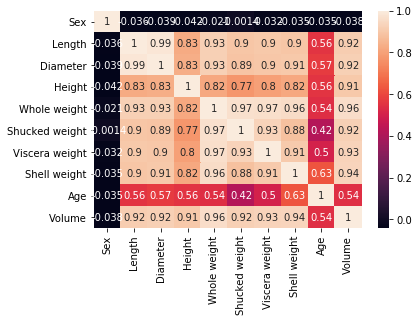

In [11]:
corr = data.corr()
sns.heatmap(corr, annot=True)

Since we are focued on predicting the age, let's focus on the correlation of the other columns to Age.

In [12]:
corr.Age.sort_values(ascending=False) 

Age               1.000000
Shell weight      0.627574
Diameter          0.574660
Height            0.557467
Length            0.556720
Volume            0.544952
Whole weight      0.540390
Viscera weight    0.503819
Shucked weight    0.420884
Sex              -0.034627
Name: Age, dtype: float64

From this heatmap, it looks like Sex is not a huge factor for Age. We can take this column out before we train our model.

In [13]:
data.drop(columns='Sex', inplace=True)
data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age,Volume
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0.015777
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0.008347
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0.030051
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0.020075
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0.006732


### Outlier Removal
Before we finally get to train our model, we want to check for any outliers. Since the dataset is relatively small, outliers may impact our ability to predict negatively. First, let's check out the age distribution.

In [14]:
age_grouped = data.groupby('Age').size()
age_grouped

Age
2.5       1
3.5       1
4.5      15
5.5      57
6.5     115
7.5     259
8.5     391
9.5     568
10.5    689
11.5    634
12.5    487
13.5    267
14.5    203
15.5    126
16.5    103
17.5     67
18.5     58
19.5     42
20.5     32
21.5     26
22.5     14
23.5      6
24.5      9
25.5      2
26.5      1
27.5      1
28.5      2
30.5      1
dtype: int64

For the sake of this example, we can limit our dataset to predict for ages between 4.5 to 22.5.

In [15]:
new_df = data.loc[(data['Age'] >= 4.5) & (data['Age'] <= 22.5)]
new_df.groupby('Age').size()

Age
4.5      15
5.5      57
6.5     115
7.5     259
8.5     391
9.5     568
10.5    689
11.5    634
12.5    487
13.5    267
14.5    203
15.5    126
16.5    103
17.5     67
18.5     58
19.5     42
20.5     32
21.5     26
22.5     14
dtype: int64

Although we have limited our dataset, we still may have outliers. Let's take a look at the most important features to see if there are outliers still.

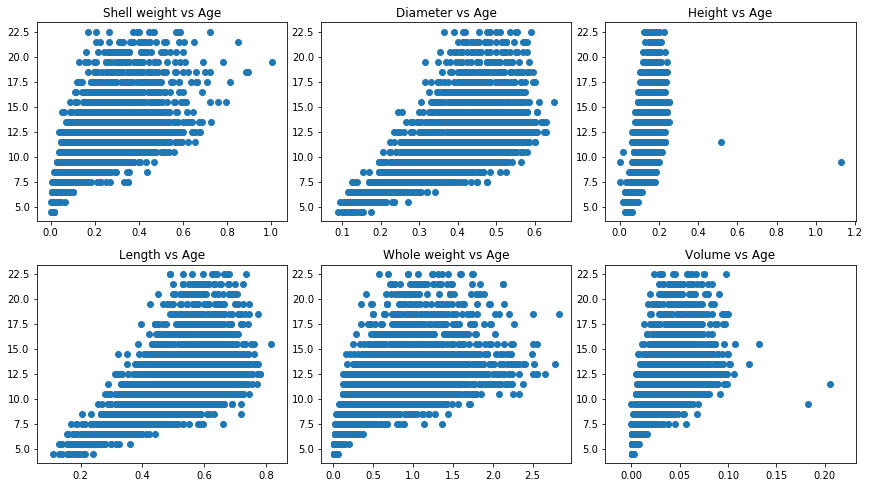

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Shell weight vs Age')
plt.scatter(new_df['Shell weight'],new_df['Age'])

plt.subplot(3,3,2)
plt.title('Diameter vs Age')
plt.scatter(new_df['Diameter'],new_df['Age'])

plt.subplot(3,3,3)
plt.title('Height vs Age')
plt.scatter(new_df['Height'],new_df['Age'])

plt.subplot(3,3,4)
plt.title('Length vs Age')
plt.scatter(new_df['Length'],new_df['Age'])

plt.subplot(3,3,5)
plt.title('Whole weight vs Age')
plt.scatter(new_df['Whole weight'],new_df['Age'])

plt.subplot(3,3,6)
plt.title('Volume vs Age')
plt.scatter(new_df['Volume'],new_df['Age'])

plt.tight_layout()

It looks like our dataset looks good for the most part, but we have some outliers in Height & Volume. Let's take those out before we train our model.

In [18]:
df = new_df[(new_df['Height'] < .4) & (new_df['Volume'] < .15)]
print('Old Length: {}\nNew Length: {}'.format(len(new_df), len(df)))

Old Length: 4153
New Length: 4151


### Train-Test Split
 Now that our data has been prepared, we will split the data into a training set and a testing set.

In [21]:
# Get X and Y
cols = []

for col in df.columns:
    if col != 'Age':
        cols.append(col)
        
x = df[cols]
y = df['Age']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, \
                                   test_size=.20, random_state=123)
len(x_train)

3320

## Linear Regression

First, we train our model.

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now, we make predictions

In [25]:
y_pred = lin_reg.predict(x_test)

In [26]:
plot_data = pd.DataFrame({'Y_Real': y_test, 'Y_Pred': y_pred})
plot_data.head()

,Y_Real,Y_Pred
1820,14.5,14.123779
2472,15.5,13.357613
1150,10.5,10.614631
1998,8.5,7.834225
3372,17.5,12.493873


In [27]:
plot_data = plot_data.sort_values(by='Y_Real')
plot_data.reset_index(inplace=True, drop=True)
plot_data.head()

,Y_Real,Y_Pred
0,4.5,4.924759
1,4.5,6.170353
2,4.5,5.945427
3,5.5,6.844051
4,5.5,7.371892


In [29]:
evs = explained_variance_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Explained Variance Score: {}\nMean Squared Error: {}\nMean Absolute Error" {}'\
     .format(evs, mse, mae))

Explained Variance Score: 0.524503987600933
Mean Squared Error: 4.4764559715095285
Mean Absolute Error" 1.5528821051341768


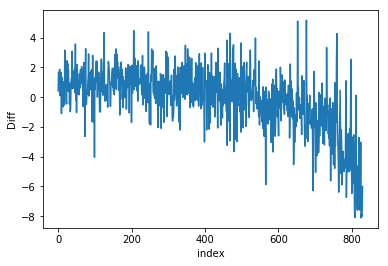

In [30]:
plot_data['Diff'] = plot_data['Y_Pred'] - plot_data['Y_Real']
plot_data.reset_index(inplace=True)
ax = sns.lineplot(x="index", y="Diff", data=plot_data)

From the looks of this chart, it looks like our predictions get less accurate as the actual Age of the fish increases. Let's try a different regression technique next.

## Polynomial Regression

In [31]:
poly_input = [('polynomial', PolynomialFeatures(degree=2)), ('modal', LinearRegression())]
pipeline = Pipeline(poly_input)
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('polynomial', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('modal', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [32]:
poly_pred = pipeline.predict(x_test)

In [33]:
plot_data = pd.DataFrame({'Y_Real': y_test, 'Y_Pred': poly_pred})
plot_data = plot_data.sort_values(by='Y_Real')
plot_data.reset_index(inplace=True, drop=True)
plot_data.head()

,Y_Real,Y_Pred
0,4.5,5.347948
1,4.5,5.991079
2,4.5,5.861156
3,5.5,6.882651
4,5.5,7.195593


In [34]:
evs = explained_variance_score(y_test, poly_pred)
mse = mean_squared_error(y_test, poly_pred)
mae = mean_absolute_error(y_test, poly_pred)

print('Explained Variance Score: {}\nMean Squared Error: {}\nMean Absolute Erroe" {}'\
     .format(evs, mse, mae))

Explained Variance Score: 0.5418464100683429
Mean Squared Error: 4.3160819034914475
Mean Absolute Erroe" 1.4919679745918777


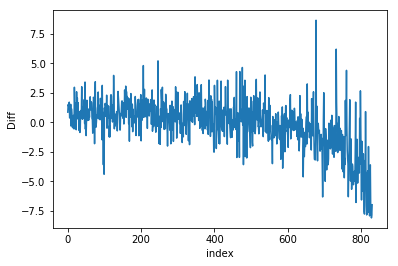

In [35]:
plot_data['Diff'] = plot_data['Y_Pred'] - plot_data['Y_Real']
plot_data.reset_index(inplace=True)
ax = sns.lineplot(x="index", y="Diff", data=plot_data)

From the looks of it, our explained variance score went up using Polynomial Regression. So we have produced a slightly better model using Polynomial Regression. Next, let's take a look at the final regression technique.

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rf_mod = RandomForestRegressor(random_state=0, n_estimators=100)
rf_mod.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [38]:
rf_pred = rf_mod.predict(x_test)

In [39]:
plot_data = pd.DataFrame({'Y_Real': y_test, 'Y_Pred': rf_pred})
plot_data = plot_data.sort_values(by='Y_Real')
plot_data.reset_index(inplace=True, drop=True)
plot_data.head()

,Y_Real,Y_Pred
0,4.5,5.01
1,4.5,5.91
2,4.5,5.92
3,5.5,7.33
4,5.5,7.72


In [41]:
evs = explained_variance_score(y_test, rf_pred)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)

print('Explained Variance Score: {}\nMean Squared Error: {}\nMean Absolute Error" {}'\
     .format(evs, mse, mae))

Explained Variance Score: 0.537090951610263
Mean Squared Error: 4.350460770156438
Mean Absolute Error" 1.500950661853189


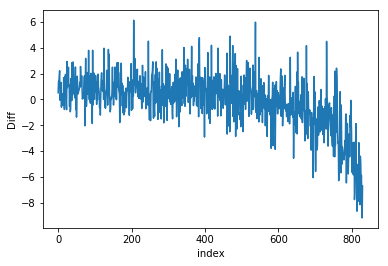

In [42]:
plot_data['Diff'] = plot_data['Y_Pred'] - plot_data['Y_Real']
plot_data.reset_index(inplace=True)
ax = sns.lineplot(x="index", y="Diff", data=plot_data)

This iteration of the Random Forest model performed worse than the Polynomial Regression model. However, we can tune the parameters of the model to see if it leads to better results.

### Hyperparameter Tuning

In [46]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [5,10, 15, 20, 25, None],    
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [25, 50, 100, 200]}

grid_search = GridSearchCV(rf_mod, params, cv = 3)

In [47]:
grid_search.fit(x_train, y_train) 

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 20, 25, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [25, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### Tuned Random Forest Regressor

In [49]:
rf_mod_tuned = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=10, min_samples_leaf=4, min_samples_split=10)
rf_mod_tuned.fit(x_train,y_train)
rf_pred = rf_mod_tuned.predict(x_test)

plot_data = pd.DataFrame({'Y_Real': y_test, 'Y_Pred': rf_pred})
plot_data = plot_data.sort_values(by='Y_Real')
plot_data.reset_index(inplace=True, drop=True)
plot_data.head()

,Y_Real,Y_Pred
0,4.5,5.040736
1,4.5,6.123881
2,4.5,6.123837
3,5.5,7.165224
4,5.5,7.736099


In [50]:
evs = explained_variance_score(y_test, rf_pred)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)

print('Explained Variance Score: {}\nMean Squared Error: {}\nMean Absolute Error" {}'\
     .format(evs, mse, mae))

Explained Variance Score: 0.5464062317025148
Mean Squared Error: 4.27788523432846
Mean Absolute Error" 1.4756879389048125


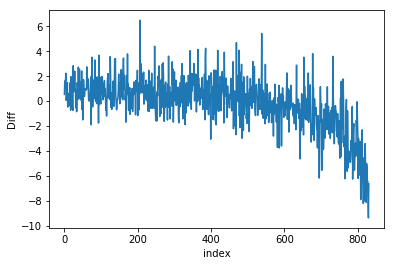

In [51]:
plot_data['Diff'] = plot_data['Y_Pred'] - plot_data['Y_Real']
plot_data.reset_index(inplace=True)
ax = sns.lineplot(x="index", y="Diff", data=plot_data)

## Summary
In this notebook, we took a look at three different regression techniques to predict the age of Abalone shellfish. Initially, using Polynomial Regression seemed to produce the best result. However, after tuning our hyperparameters to find the best input of our Random Forest model - we saw better results.